In [72]:
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd
from scipy.linalg import pinv
from itertools import product
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import shutil
from typing import Tuple
import anndata
from anndata import AnnData
from scipy.io import mmread
import requests
import warnings

In [40]:
"""
Download, read, and preprocess Mcfarland et al. (2020) expression data.

Single-cell expression data from Mcfarland et al. Multiplexed single-cell
transcriptional response profiling to define cancer vulnerabilities and therapeutic
mechanism of action. Nature Communications (2020).
"""


def download_binary_file(file_url: str, output_path: str) -> None:
    """
    Download binary data file from a URL.

    Args:
    ----
        file_url: URL where the file is hosted.
        output_path: Output path for the downloaded file.

    Returns
    -------
        None.
    """
    request = requests.get(file_url)
    with open(output_path, "wb") as f:
        f.write(request.content)
    print(f"Downloaded data from {file_url} at {output_path}")

    
    
def download_mcfarland_2020(output_path: str) -> None:
    """
    Download Mcfarland et al. 2020 data from the hosting URLs.

    Args:
    ----
        output_path: Output path to store the downloaded and unzipped
        directories.

    Returns
    -------
        None. File directories are downloaded and unzipped in output_path.
    """
    idasanutlin_url = "https://figshare.com/ndownloader/files/18716351"
    idasanutlin_output_filename = os.path.join(output_path, "idasanutlin.zip")

    download_binary_file(idasanutlin_url, idasanutlin_output_filename)
    idasanutlin_output_dir = idasanutlin_output_filename.replace(".zip", "")
    shutil.unpack_archive(idasanutlin_output_filename, idasanutlin_output_dir)

    dmso_url = "https://figshare.com/ndownloader/files/18716354"
    dmso_output_filename = os.path.join(output_path, "dmso.zip")

    download_binary_file(dmso_url, dmso_output_filename)
    dmso_output_dir = dmso_output_filename.replace(".zip", "")
    shutil.unpack_archive(dmso_output_filename, dmso_output_dir)


def _read_mixseq_df(directory: str) -> pd.DataFrame:
    data = mmread(os.path.join(directory, "matrix.mtx"))
    barcodes = pd.read_table(os.path.join(directory, "barcodes.tsv"), header=None)
    classifications = pd.read_csv(os.path.join(directory, "classifications.csv"))
    classifications["cell_line"] = np.array(
        [x.split("_")[0] for x in classifications.singlet_ID.values]
    )
    gene_names = pd.read_table(os.path.join(directory, "genes.tsv"), header=None)

    df = pd.DataFrame(
        data.toarray(),
        columns=barcodes.iloc[:, 0].values,
        index=gene_names.iloc[:, 0].values,
    )
    return df


def _get_tp53_mutation_status(directory: str) -> np.array:
    # Taken from https://cancerdatascience.org/blog/posts/mix-seq/
    TP53_WT = [
        "LNCAPCLONEFGC_PROSTATE",
        "DKMG_CENTRAL_NERVOUS_SYSTEM",
        "NCIH226_LUNG",
        "RCC10RGB_KIDNEY",
        "SNU1079_BILIARY_TRACT",
        "CCFSTTG1_CENTRAL_NERVOUS_SYSTEM",
        "COV434_OVARY",
    ]

    classifications = pd.read_csv(os.path.join(directory, "classifications.csv"))
    TP53_mutation_status = [
        "Wild Type" if x in TP53_WT else "Mutation"
        for x in classifications.singlet_ID.values
    ]
    return np.array(TP53_mutation_status)


def read_mcfarland_2020(file_directory: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Read the expression data for Mcfarland et al. 2020 in the given directory.

    Args:
    ----
        file_directory: Directory containing Mcfarland et al. 2020 data.

    Returns
    -------
        Two data frames of raw count expression data. The first contains
        single-cell gene expression count data from cancer cell lines exposed to
        idasanutlin with cell identification barcodes as column names and gene IDs as
        indices. The second contains count data with the same format from samples
        exposed to a control solution (DMSO).
    """
    idasanutlin_dir = os.path.join(
        file_directory, "idasanutlin", "Idasanutlin_24hr_expt1"
    )
    idasanutlin_df = _read_mixseq_df(idasanutlin_dir)

    dmso_dir = os.path.join(file_directory, "dmso", "DMSO_24hr_expt1")
    dmso_df = _read_mixseq_df(dmso_dir)

    return idasanutlin_df, dmso_df


def preprocess_mcfarland_2020(download_path: str, n_top_genes: int) -> AnnData:
    """
    Preprocess expression data from Mcfarland et al., 2020.

    Args:
    ----
        download_path: Path containing the downloaded Mcfarland et al. 2020 data files.
        n_top_genes: Number of most variable genes to retain.

    Returns
    -------
        An AnnData object containing single-cell expression data. The layer
        "count" contains the count data for the most variable genes. The X
        variable contains the total-count-normalized and log-transformed data
        for the most variable genes (a copy with all the genes is stored in
        .raw).
    """

    idasanutlin_df, dmso_df = read_mcfarland_2020(download_path)
    idasanutlin_df, dmso_df = idasanutlin_df.transpose(), dmso_df.transpose()

    m, n = idasanutlin_df.shape
    p, k = dmso_df.shape


    idasanutlin_adata = AnnData(idasanutlin_df)
    idasanutlin_dir = os.path.join(
        download_path, "idasanutlin", "Idasanutlin_24hr_expt1",
    )
    idasanutlin_adata.obs["TP53_mutation_status"] = _get_tp53_mutation_status(
        idasanutlin_dir
    )
    idasanutlin_adata.obs["condition"] = np.repeat(
        "Idasanutlin", idasanutlin_adata.shape[0]
    )

    dmso_adata = AnnData(dmso_df)
    dmso_dir = os.path.join(download_path, "dmso", "DMSO_24hr_expt1")
    dmso_adata.obs["TP53_mutation_status"] = _get_tp53_mutation_status(dmso_dir)
    dmso_adata.obs["condition"] = np.repeat("DMSO", dmso_adata.shape[0])

    full_adata = anndata.concat([idasanutlin_adata, dmso_adata])
    full_adata.layers["count"] = full_adata.X.copy()
    sc.pp.normalize_total(full_adata)
    sc.pp.log1p(full_adata)
    full_adata.raw = full_adata
    sc.pp.highly_variable_genes(
        full_adata,
        flavor="seurat_v3",
        n_top_genes=n_top_genes,
        layer="count",
        subset=True,
    )
    full_adata = full_adata[
        full_adata.layers["count"].sum(1) != 0
    ]  # Remove cells with all zeros.

    full_data = full_adata.to_df()

    return full_adata

In [41]:
root_data_path = ""   # local computer data path to downloaad the dataset. 

data = preprocess_mcfarland_2020(root_data_path, 1000)

C:\Users\Eric\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\Eric\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\Eric\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [42]:
foreground = data[:3096, ]
background = data[3097:, ]

labels = np.where(foreground.obs['TP53_mutation_status'] == 'Mutation', 1, 0)

foreground = foreground.to_df()
background = background.to_df()
foreground.head()

,ENSG00000188290,ENSG00000187608,ENSG00000178821,ENSG00000187730,ENSG00000157873,ENSG00000142606,ENSG00000234546,ENSG00000162444,ENSG00000116661,ENSG00000120937,...,ENSG00000184012,ENSG00000160180,ENSG00000160181,ENSG00000160182,ENSG00000160200,ENSG00000160213,ENSG00000224930,ENSG00000142156,ENSG00000142173,ENSG00000160307
AAACCTGAGATCCTGT-1,1.184084,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,1.184084,0.0,0.0,0.0,0.000000
AAACCTGAGGATGTAT-1,0.655526,1.198575,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,1.728248,0.0,0.0,0.0,0.000000
AAACCTGCAGAGCCAA-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,2.579365,0.0,0.0,0.0,2.579365
AAACCTGCAGCGTCCA-1,0.000000,0.000000,0.796392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,2.373994,0.0,0.0,0.0,0.000000
AAACCTGGTACCTACA-1,0.000000,0.914139,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.914139,2.136901,0.0,0.0,1.383605,0.0,0.0,0.0,0.000000


In [43]:
foreground_barcodes = foreground.index.astype(str).str.strip()  # Convert to string and strip spaces
classifications_foreground['barcode'] = classifications_foreground['barcode'].astype(str).str.strip()  # Convert to string and remove spaces
merged_data = pd.merge(foreground_barcodes.to_frame(name='barcode'), classifications_foreground, left_on='barcode', right_on='barcode', how='left')
cell_types = merged_data['singlet_ID'].values

background_barcodes = background.index.astype(str).str.strip()  # Convert to string and strip spaces
classifications_background['barcode'] = classifications_background['barcode'].astype(str).str.strip()  # Convert to string and remove spaces
merged_data_background = pd.merge(background_barcodes.to_frame(name='barcode'), classifications_background, left_on='barcode', right_on='barcode', how='left')
cell_types_background = merged_data_background['singlet_ID'].values

In [44]:
X = foreground.to_numpy()
Y = background.to_numpy()

In [73]:
os.chdir('C:/Users/Eric/OneDrive - University of North Carolina at Chapel Hill/dissertation work/project 2 - contrastive cur/')
from main import*

In [74]:
c = 10
k = 5
cols_contrastive = ccur(X,Y,k,c)[0]
gene_names[cols_contrastive]

array(['ENSG00000186994', 'ENSG00000196734', 'ENSG00000183273',
       'ENSG00000175600', 'ENSG00000240386', 'ENSG00000135423',
       'ENSG00000161513', 'ENSG00000234546', 'ENSG00000134545',
       'ENSG00000148357'], dtype=object)

In [47]:
cols_foreground = deterministic_cur(X, k, c)[3]
gene_names[cols_foreground]

array(['ENSG00000196754', 'ENSG00000108298', 'ENSG00000125148',
       'ENSG00000100097', 'ENSG00000111057', 'ENSG00000198034',
       'ENSG00000026025', 'ENSG00000125691', 'ENSG00000124762',
       'ENSG00000197956'], dtype=object)

In [48]:
cols_union = deterministic_cur(np.concatenate((X,Y)), k, c)[3]
gene_names[cols_union]

array(['ENSG00000196754', 'ENSG00000108298', 'ENSG00000100097',
       'ENSG00000111057', 'ENSG00000125148', 'ENSG00000198034',
       'ENSG00000026025', 'ENSG00000125691', 'ENSG00000108106',
       'ENSG00000245532'], dtype=object)

In [67]:
alpha = 1

constrastive_cov = np.cov(X, rowvar = False) - alpha * np.cov(Y, rowvar = False)
eigenvalues, eigenvectors = np.linalg.eig(constrastive_cov)

first_pc = eigenvectors[:, np.argmax(eigenvalues)]  
top_indices = np.argsort(np.abs(first_pc))[-c:] 
gene_names[top_indices]  


array(['ENSG00000116717', 'ENSG00000197061', 'ENSG00000175600',
       'ENSG00000161513', 'ENSG00000108106', 'ENSG00000185088',
       'ENSG00000115129', 'ENSG00000135679', 'ENSG00000130513',
       'ENSG00000124762'], dtype=object)

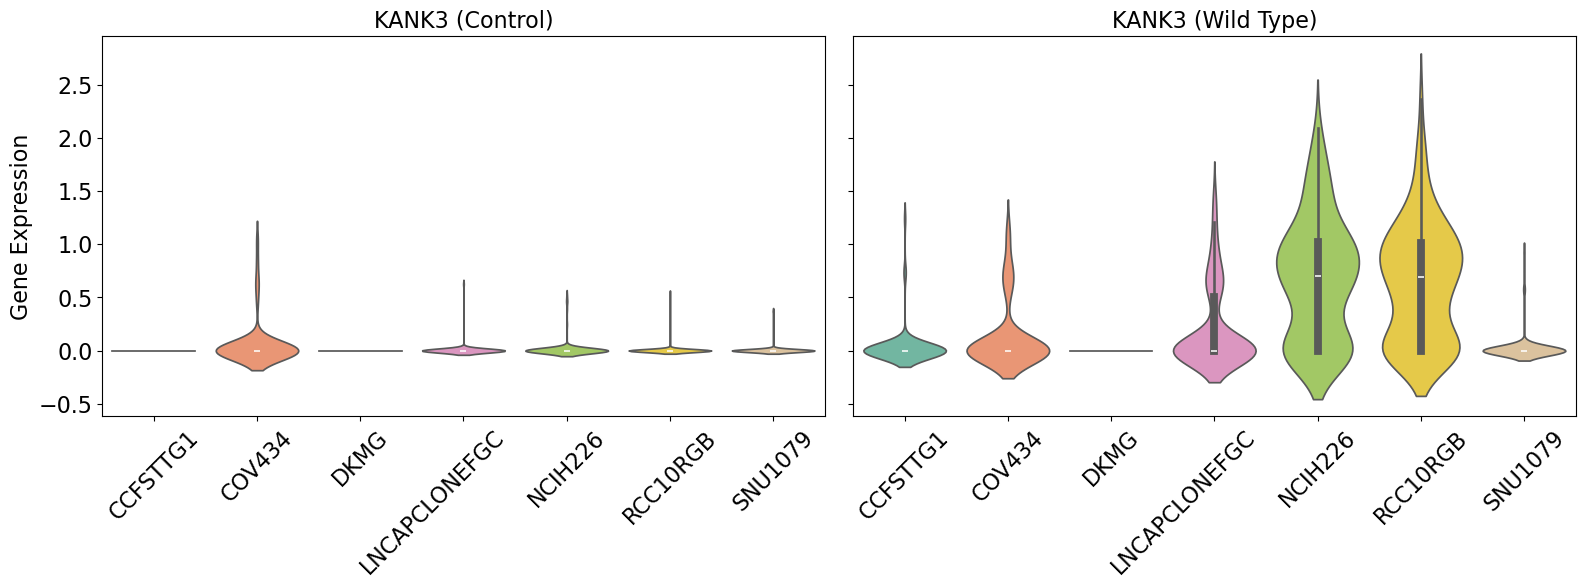

In [51]:
warnings.filterwarnings("ignore")

gene_index = cols_contrastive[0]  

gene_expression_foreground = foreground.iloc[:, gene_index]
gene_expression_background = background.iloc[:, gene_index]

selected_cell_types = [
    'CCFSTTG1', 'COV434', 'DKMG',
    'LNCAPCLONEFGC', 'NCIH226',
    'RCC10RGB', 'SNU1079'
]

cell_type_map = {
    'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM': 'CCFSTTG1',
    'COV434_OVARY': 'COV434',
    'DKMG_CENTRAL_NERVOUS_SYSTEM': 'DKMG',
    'LNCAPCLONEFGC_PROSTATE': 'LNCAPCLONEFGC',
    'NCIH226_LUNG': 'NCIH226',
    'RCC10RGB_KIDNEY': 'RCC10RGB',
    'SNU1079_BILIARY_TRACT': 'SNU1079'
}

cell_types_short = pd.Series(cell_types).replace(cell_type_map).values
cell_types_background_short = pd.Series(cell_types_background).replace(cell_type_map).values

data_foreground = pd.DataFrame({
    'Gene Expression': gene_expression_foreground.values,
    'Cell Type': cell_types_short,
    'Group': labels  # 0 or 1 for mutation
})

data_background = pd.DataFrame({
    'Gene Expression': gene_expression_background,
    'Cell Type': cell_types_background_short,
    'Group': ['Control'] * len(gene_expression_background)  # Label as 'Control'
})

data_foreground_filtered = data_foreground[data_foreground['Cell Type'].isin(selected_cell_types)]
data_background_filtered = data_background[data_background['Cell Type'].isin(selected_cell_types)]

data_mutation_0 = data_foreground_filtered[data_foreground_filtered['Group'] == 0]
data_mutation_1 = data_foreground_filtered[data_foreground_filtered['Group'] == 1]


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
palette = sns.color_palette("Set2", len(selected_cell_types))

title_fontsize = 16
axis_label_fontsize = 16
tick_label_fontsize = 16

sns.violinplot(
    x='Cell Type', y='Gene Expression', data=data_background_filtered, 
    order=selected_cell_types, ax=axes[0], palette=palette
)
axes[0].set_title("KANK3 (Control)", fontsize=title_fontsize)
axes[0].set_xlabel("Cell Type", fontsize=axis_label_fontsize)
axes[0].set_ylabel("Gene Expression", fontsize=axis_label_fontsize)
axes[0].tick_params(axis='x', rotation=45, labelsize=tick_label_fontsize)
axes[0].tick_params(axis='y', labelsize=tick_label_fontsize)

tick_labels = axes[0].get_xticks()
tick_labels_text = axes[0].get_xticklabels()
fourth_label = tick_labels_text[3]
axes[0].text(
    tick_labels[3] - 0.3, -0.7, fourth_label.get_text(),
    fontsize=tick_label_fontsize, ha='center', va='top', rotation=45
)
fourth_label.set_visible(False) 
axes[0].set_xlabel('') 
sns.violinplot(
    x='Cell Type', y='Gene Expression', data=data_mutation_0, 
    order=selected_cell_types, ax=axes[1], palette=palette
)
axes[1].set_title("KANK3 (Wild Type)", fontsize=title_fontsize)
axes[1].set_xlabel("Cell Type", fontsize=axis_label_fontsize)
axes[1].tick_params(axis='x', rotation=45, labelsize=tick_label_fontsize)
axes[1].tick_params(axis='y', labelsize=tick_label_fontsize)

tick_labels = axes[1].get_xticks()
tick_labels_text = axes[1].get_xticklabels()
fourth_label = tick_labels_text[3]
axes[1].text(
    tick_labels[3] - 0.3, -0.7, fourth_label.get_text(),
    fontsize=tick_label_fontsize, ha='center', va='top', rotation=45
)
fourth_label.set_visible(False)  

axes[1].set_xlabel('') 

plt.tight_layout()
plt.show()


In [68]:
r = 100
contrastive_rows = deterministic_cur(X[:,top_indices],k,r)[4]
foreground_rows = deterministic_cur(X,k, r)[4]

In [69]:
def calculate_proportion(rows, labels):
    """
    Calculate the proportion of 0 and 1 in the selected rows based on the labels array.
    """
    selected_labels = labels[rows]
    total = len(selected_labels)
    count_0 = np.sum(selected_labels == 0)
    count_1 = np.sum(selected_labels == 1)
    proportion_0 = count_0 / total
    proportion_1 = count_1 / total
    return count_0, count_1, proportion_0, proportion_1

count_0_contrastive, count_1_contrastive, prop_0_contrastive, prop_1_contrastive = calculate_proportion(contrastive_rows, labels)
count_0_foreground, count_1_foreground, prop_0_foreground, prop_1_foreground = calculate_proportion(foreground_rows, labels)

total_0 = np.sum(labels == 0)
total_1 = np.sum(labels == 1)
total = len(labels)
total_prop_0 = total_0 / total
total_prop_1 = total_1 / total

print("Proportion in rows_contrastive:")
print(f"Count 0: {count_0_contrastive}, Count 1: {count_1_contrastive}, Proportion 0: {prop_0_contrastive:.2f}, Proportion 1: {prop_1_contrastive:.2f}")

print("\nProportion in rows_foreground:")
print(f"Count 0: {count_0_foreground}, Count 1: {count_1_foreground}, Proportion 0: {prop_0_foreground:.2f}, Proportion 1: {prop_1_foreground:.2f}")

print("\nTotal counts and proportions across all labels:")
print(f"Total Count 0: {total_0}, Total Count 1: {total_1}, Total Proportion 0: {total_prop_0:.2f}, Total Proportion 1: {total_prop_1:.2f}")


Proportion in rows_contrastive:
Count 0: 99, Count 1: 1, Proportion 0: 0.99, Proportion 1: 0.01

Proportion in rows_foreground:
Count 0: 62, Count 1: 38, Proportion 0: 0.62, Proportion 1: 0.38

Total counts and proportions across all labels:
Total Count 0: 671, Total Count 1: 2425, Total Proportion 0: 0.22, Total Proportion 1: 0.78


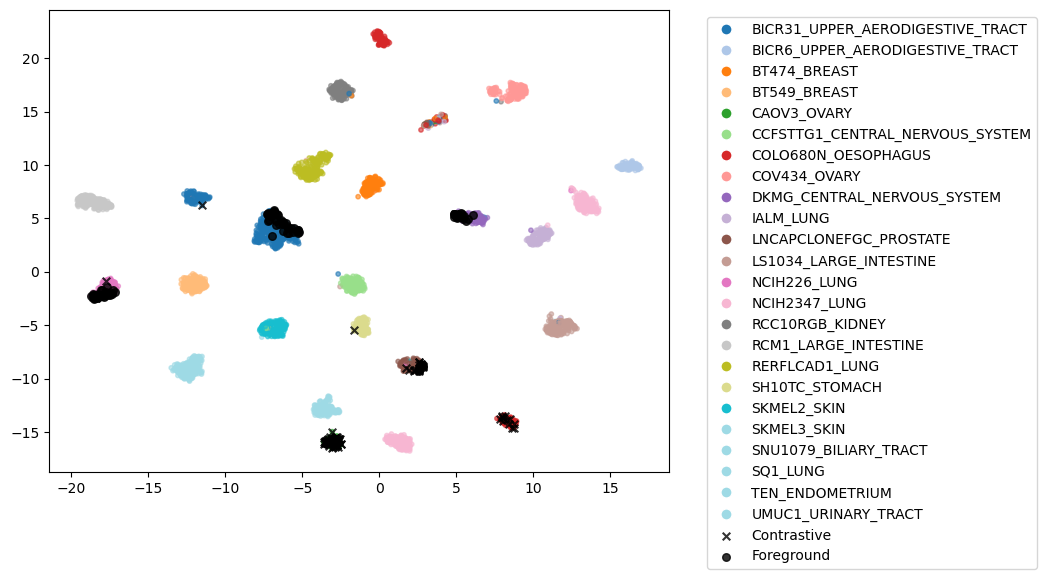

In [70]:
adata = sc.AnnData(target.values)
adata.obs['barcode'] = target.index  
adata.var['gene_name'] = target.columns  

adata.obs['cell_types'] = pd.Categorical(cell_types)  

sc.pp.neighbors(adata, n_neighbors=30)  
sc.tl.umap(adata)

contrastive_indices = adata.obs.index[adata.obs['barcode'].isin(cell_names[contrastive_rows])].tolist()
foreground_indices = adata.obs.index[adata.obs['barcode'].isin(cell_names[foreground_rows])].tolist()

contrastive_indices = [int(i) for i in contrastive_indices]
foreground_indices = [int(i) for i in foreground_indices]

coords = adata.obsm['X_umap']
cell_types = adata.obs['cell_types']

plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=cell_types.cat.codes, cmap='tab20', s=10, alpha=0.6)

plt.scatter(coords[contrastive_indices, 0], coords[contrastive_indices, 1], 
            color='black', marker='x', s=30, label='Contrastive', alpha=0.8)

plt.scatter(coords[foreground_indices, 0], coords[foreground_indices, 1], 
            color='black', marker='o', s=30, label='Foreground', alpha=0.8)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(i), markersize=8, label=cat)
           for i, cat in enumerate(cell_types.cat.categories)]
plt.legend(handles=handles + plt.gca().get_legend_handles_labels()[0], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [71]:
cell_type_assignments = adata.obs['cell_types']

contrastive_type_counts = cell_type_assignments[contrastive_indices].value_counts()
foreground_type_counts = cell_type_assignments[foreground_indices].value_counts()
true_type_counts = adata.obs['cell_types'].value_counts()

total_contrastive = len(contrastive_indices)
total_foreground = len(foreground_indices)

contrastive_proportions = contrastive_type_counts / total_contrastive
foreground_proportions = foreground_type_counts / total_foreground
total_cells = len(adata)
true_type_proportions = true_type_counts / total_cells

proportions_df = pd.DataFrame({
    'CCUR': contrastive_proportions,
    'CUR': foreground_proportions
})
proportions_df['True Proportion'] = true_type_proportions

proportions_df = proportions_df[(proportions_df > 0).any(axis=1)]
print(proportions_df)

                                  CCUR   CUR  True Proportion
BICR31_UPPER_AERODIGESTIVE_TRACT  0.00  0.38         0.089470
BICR6_UPPER_AERODIGESTIVE_TRACT   0.01  0.00         0.035853
BT474_BREAST                      0.00  0.00         0.022933
BT549_BREAST                      0.00  0.00         0.042313
CAOV3_OVARY                       0.00  0.00         0.045220
CCFSTTG1_CENTRAL_NERVOUS_SYSTEM   0.60  0.00         0.024871
COLO680N_OESOPHAGUS               0.00  0.00         0.041667
COV434_OVARY                      0.00  0.00         0.024225
DKMG_CENTRAL_NERVOUS_SYSTEM       0.12  0.00         0.030039
IALM_LUNG                         0.00  0.00         0.045543
LNCAPCLONEFGC_PROSTATE            0.01  0.23         0.036499
LS1034_LARGE_INTESTINE            0.00  0.00         0.037791
NCIH226_LUNG                      0.16  0.09         0.030362
NCIH2347_LUNG                     0.00  0.00         0.051357
RCC10RGB_KIDNEY                   0.09  0.30         0.036822
RCM1_LAR